+ Reference : https://github.com/labmlai/annotated_deep_learning_paper_implementations/tree/master/labml_nn/diffusion/ddpm        


In [1]:
from typing import List, Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from tqdm import tqdm

from labml import lab, tracker, experiment, monit
from labml.configs import BaseConfigs, option

from unet import UNet
from module import Module
from gather import gather
from DenoiseDiffusion import DenoiseDiffusion
from evaluate import Sampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 64
epochs = 100
n_steps = 1000
image_channels = 3
image_size = 128
n_channels = 64
ch_mults = [1,2,2,4]
is_attn = [False,False,False,True]
n_samples = 16
lr = 2e-5
data_path = '/home/sh/lab/GAN/data/img_align_celeba'

# Data Load

In [3]:
transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),])

dataset = datasets.ImageFolder(data_path, transform=transform)
loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=4)

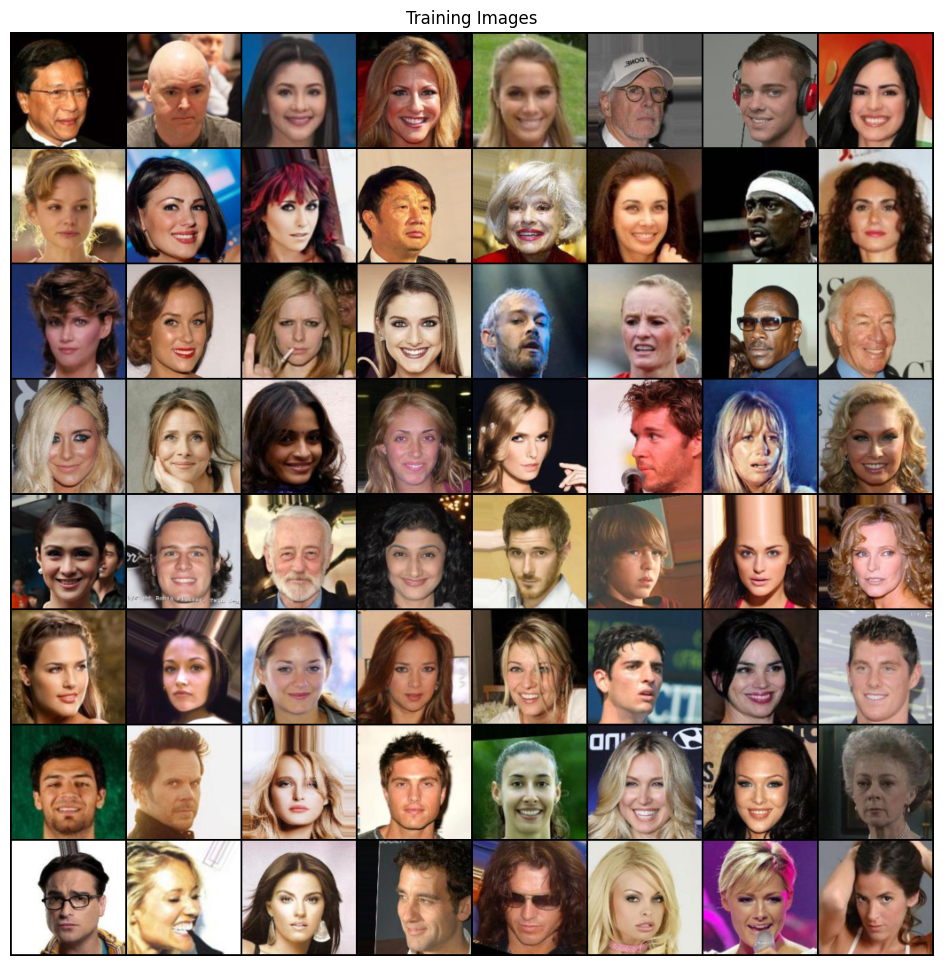

In [4]:
one_batch = next(iter(loader))
plt.figure(figsize=(12,12))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(one_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Define Denoise Diffusion

In [6]:
class DenoiseDiffusion:
    """
    eps_model : ϵ_θ(x_t, t) model
    n_steps : t
    """
    def __init__(self, eps_model:nn.Module, n_steps:int, device:torch.device):
        super().__init__()
        self.eps_model = eps_model
        # beta1 ~ betaT linearly increasing variance schedule
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta  # sigma^2 = beta (in paper)
        
    def q_xt_x0(self, x0:torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - gather(self.alpha_bar, t)
        
        return mean, var
    
    def q_sample(self, x0:torch.Tensor, t:torch.Tensor, eps: Optional[torch.Tensor] = None):
        
        if eps is None:
            eps = torch.randn_like(x0)
            
        mean, var = self.q_xt_x0(x0, t)
        
        return mean + (var ** 0.5) * eps
    
    def p_sample(self, xt:torch.Tensor, t:torch.Tensor):
        
        eps_theta = self.eps_model(xt, t)
        alpha_bar = gather(self.alpha_bar, t)
        alpha = gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = gather(self.sigma2, t)
        eps = torch.randn(xt.shape, device=xt.device)
        
        return mean + (var ** .5) * eps
    
    def loss(self, x0:torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
             
        if noise is None:
            noise = torch.randn_like(x0)
            
        xt = self.q_sample(x0, t, eps=noise)
        eps_theta = self.eps_model(xt, t)
        
        return F.mse_loss(noise, eps_theta)

# Train

In [13]:
def sample(n_steps):
    
    with torch.no_grad():
        x = torch.randn([n_samples, image_channels, image_size, image_size], device=device)
        
        # Remove noise for time step t
        for t_ in range(n_steps):
            t = n_steps - t_ -1
            x = diffusion.p_sample(x, x.new_full((n_samples,),t,dtype=torch.long))
            
            sample_list.append(x)

In [14]:
model = UNet(image_channels, n_channels,ch_mults,is_attn).to(device)
diffusion = DenoiseDiffusion(eps_model=model, n_steps=1000, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
loss_list = []
avg_loss_list = []
sample_list = []

# For each epoch
for epoch in range(epochs):
    total_loss = 0.0
    
    # For each batch in the dataloader
    for i, data in enumerate(tqdm(loader)):
        
        data = data[0].to(device)
        optimizer.zero_grad()
        
        loss = diffusion.loss(data)
        loss.backward()
        
        optimizer.step()
        
        loss_list.append(loss.item())
        total_loss += loss.item()
        
    avg_loss = total_loss / len(loader)
    avg_loss_list.append(avg_loss)   
    
        
    if epoch % 10 == 0:
        torch.save(
            model.state_dict(), f"checkpoint/model_{str(i + 1).zfill(3)}.pt"
        )
        torch.save(
            optimizer.state_dict(), f"checkpoint/optim_{str(i + 1).zfill(3)}.pt"
        )
        
    print('[%d/%d]\tLoss: %.4f'
            % (epoch+1, epochs, avg_loss))

100%|███████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [59:13<00:00,  1.12s/it]


[1/100]	Loss: 0.0547


100%|███████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [59:11<00:00,  1.12s/it]


[2/100]	Loss: 0.0135


100%|███████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [59:12<00:00,  1.12s/it]


[3/100]	Loss: 0.0102


100%|███████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [59:12<00:00,  1.12s/it]


[4/100]	Loss: 0.0089


100%|███████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [59:12<00:00,  1.12s/it]


[5/100]	Loss: 0.0085


100%|███████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [59:12<00:00,  1.12s/it]


[6/100]	Loss: 0.0081


100%|███████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [59:14<00:00,  1.12s/it]


[7/100]	Loss: 0.0079


100%|███████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [59:12<00:00,  1.12s/it]


[8/100]	Loss: 0.0076


100%|███████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [59:15<00:00,  1.12s/it]


[9/100]	Loss: 0.0076


100%|███████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [59:15<00:00,  1.12s/it]


[10/100]	Loss: 0.0075


100%|███████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [59:16<00:00,  1.12s/it]


[11/100]	Loss: 0.0074


  8%|███████▏                                                                                | 259/3166 [04:51<54:33,  1.13s/it]


KeyboardInterrupt: 

+ gpu resource issue로 인해 10epochs만 돌렸음

# Visualization

## Train 10 epochs 가중치 입히기

In [5]:
model = UNet(image_channels, n_channels,ch_mults,is_attn).to(device)
diffusion = DenoiseDiffusion(eps_model=model, n_steps=1000, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [6]:
model.load_state_dict(torch.load('/home/sh/lab/GAN/diffusion/checkpoint/model_3166.pt'))

<All keys matched successfully>

In [7]:
optimizer.load_state_dict(torch.load('/home/sh/lab/GAN/diffusion/checkpoint/optim_3166.pt'))

## Test image load

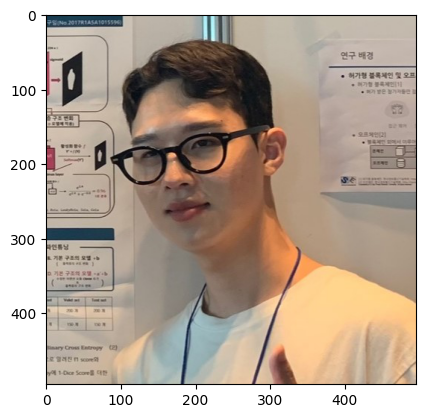

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 이미지 파일 로드
image_path = glob.glob('/home/sh/lab/GAN/diffusion/scj.jpg')[0]
img = Image.open(image_path)

# PIL 이미지를 NumPy 배열로 변환
img = np.array(img)

# 이미지 표시
plt.imshow(img)
plt.show()

## 간단한 전처리

In [ ]:
img = torch.tensor(img).to(torch.float32) / 255.0
img = img.permute(2,0,1).unsqueeze(0)

resize = transforms.Compose([
    transforms.Resize((128, 128)),  # 리사이징
])

img = resize(img)

## Time Step에 따른 noise 입히는 과정

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


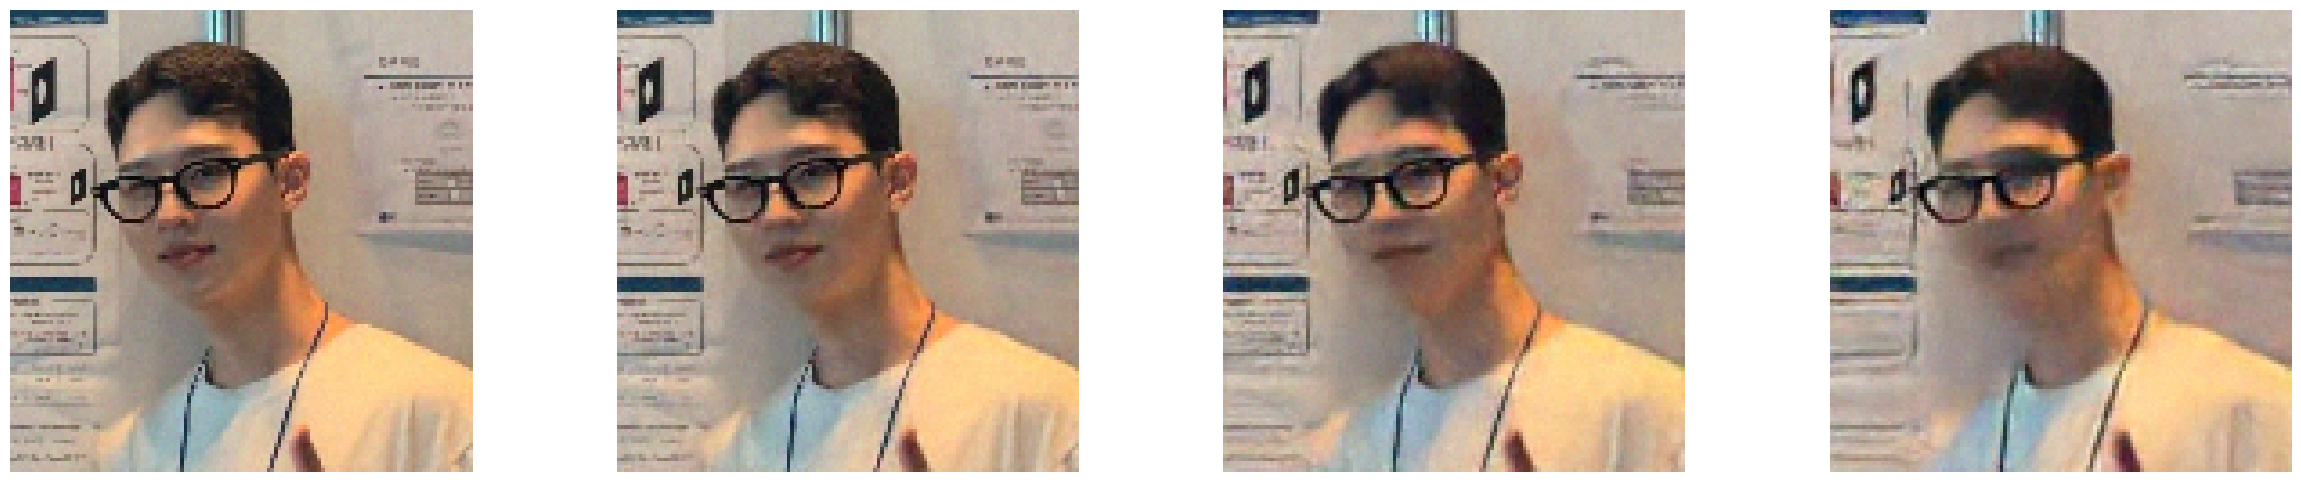

In [14]:
# sample_x0 = Sampler(diffusion=diffusion, image_channels=3, image_size=32, device=device)._sample_x0(img.to(device), 50)

fig = plt.figure(figsize=(30,6))                 
sampler = Sampler(diffusion=diffusion, image_channels=3, image_size=32, device=device)
n_step_list = [5, 10, 30, 50]

for i in range(len(n_step_list)):
    
    _=plt.subplot(1,4,i+1)
    sample_x0 =  sampler._sample_x0(img.to(device), n_step_list[i])
    _=plt.imshow(sample_x0[0].cpu().detach().numpy().transpose(1,2,0))
    _=plt.axis('off')
    